In [196]:
import os
import pandas as pd
import numpy as np
from IPython.display import display
import six
import xarray as xr
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import dates

from stompy import utils
from stompy import filters
from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver
from stompy import xr_utils
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
import stompy.plot.cmap as scmap
from stompy.spatial import field, proj_utils 
from stompy.model import data_comparison
%matplotlib notebook

In [142]:
turbo=scmap.load_gradient('turbo.cpt')

In [143]:
cache_dir="cache"
os.path.exists(cache_dir) or os.makedirs(cache_dir)

True

In [228]:
six.moves.reload_module(sun_driver)
models=[
#modelA=sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_009-20170901/")
#modelA=sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_010-201706/")
#    sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_011-201706/"),
#    sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_012-201706/"),
#    sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_012-201706-tvd/"),
#    sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_013-201706/"),
#    sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_015-201711/"),
#    sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/old/merge_016-201709/"),
#    sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merged_018_20180715/"),
#    sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merged_020_20180615/"),
     sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merged_021_20180615/")
]

for m in models:
    assert m is not None,"Failed to load"

In [229]:
modelA=models[-1]
for m in models:
    m.projection="EPSG:26910"
    
start=np.datetime64("2017-06-01") # or add a 1 month spinup

end  =max([m.run_stop for m in models])

if len(models)>1:
    for m in models:
        m.label=os.path.basename(m.run_dir)
else:
    models[0].label='Model'
    
fig_dir=os.path.join(modelA.run_dir,'figs-20200129')
os.path.exists(fig_dir) or os.makedirs(fig_dir)

True

In [146]:
def noaa_water_level(station,start,stop,**kw):
    ds=noaa_coops.coops_dataset_product(station=station,product='water_level',
                                        start_date=start,end_date=stop,
                                        cache_dir=cache_dir,clip=True)
    ds=ds.set_coords(['lon','lat'])
    da=ds.water_level.isel(station=0)
    da.attrs.update(kw)
    return da
alameda_wl=noaa_water_level(9414750,start,end,name="NOAA Alameda")
pointreyes_wl=noaa_water_level(9415020,start,end,name="NOAA Point Reyes")
sanfran_wl=noaa_water_level(9414290,start,end,name="NOAA Fort Point")
coyote_wl=noaa_water_level(9414575,start,end,name="NOAA Coyote Creek")
richmond_wl=noaa_water_level(9414863,start,end,name="NOAA Richmond")
portchicago_wl=noaa_water_level(9415144,start,end,name="NOAA Port Chicago")


INFO:noaa_coops:Cached   2017-06-01 00:00:00 -- 2017-07-01 00:00:00
INFO:noaa_coops:Cached   2017-07-01 00:00:00 -- 2017-08-01 00:00:00
INFO:noaa_coops:Cached   2017-08-01 00:00:00 -- 2017-09-01 00:00:00
INFO:noaa_coops:Cached   2017-09-01 00:00:00 -- 2017-10-01 00:00:00
INFO:noaa_coops:Cached   2017-10-01 00:00:00 -- 2017-11-01 00:00:00
INFO:noaa_coops:Cached   2017-11-01 00:00:00 -- 2017-12-01 00:00:00
INFO:noaa_coops:Cached   2017-12-01 00:00:00 -- 2018-01-01 00:00:00
INFO:noaa_coops:Cached   2018-01-01 00:00:00 -- 2018-02-01 00:00:00
INFO:noaa_coops:Cached   2018-02-01 00:00:00 -- 2018-03-01 00:00:00
INFO:noaa_coops:Cached   2018-03-01 00:00:00 -- 2018-04-01 00:00:00
INFO:noaa_coops:Cached   2018-04-01 00:00:00 -- 2018-05-01 00:00:00
INFO:noaa_coops:Cached   2018-05-01 00:00:00 -- 2018-06-01 00:00:00
INFO:noaa_coops:Cached   2018-06-01 00:00:00 -- 2018-07-01 00:00:00
INFO:noaa_coops:Cached   2017-06-01 00:00:00 -- 2017-07-01 00:00:00
INFO:noaa_coops:Cached   2017-07-01 00:00:00 -- 

<IPython.core.display.Javascript object>


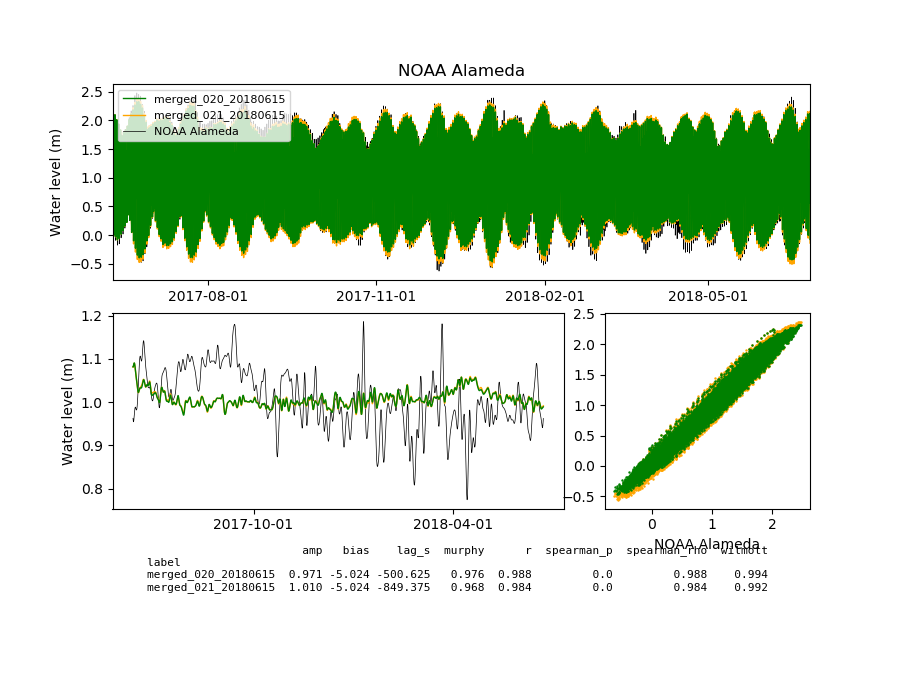

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/dates.py:1323: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  ' Defaulting to {0}.'.format(interval))


<IPython.core.display.Javascript object>


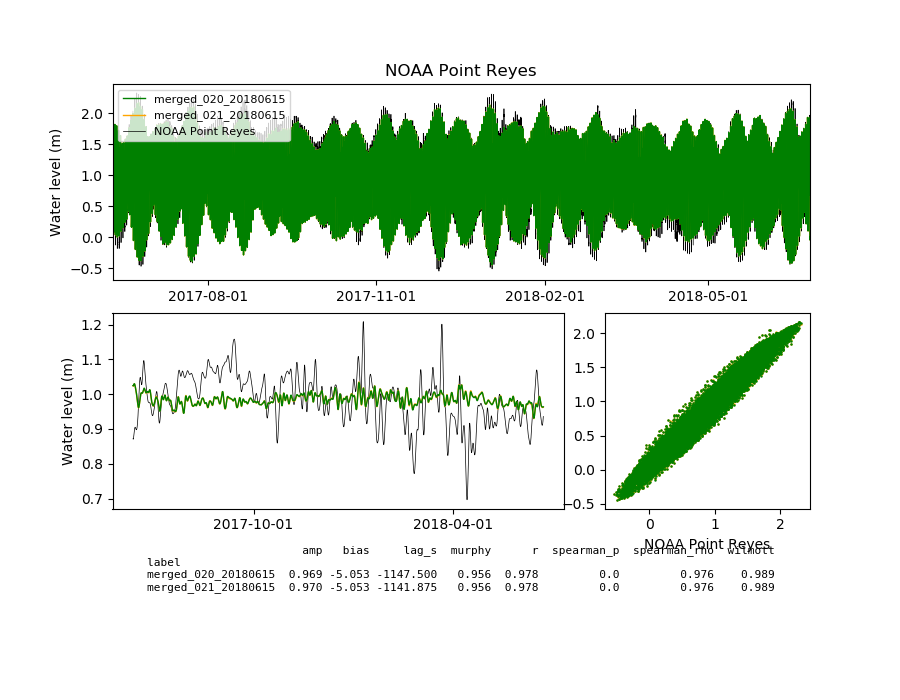

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/dates.py:1323: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  ' Defaulting to {0}.'.format(interval))


<IPython.core.display.Javascript object>


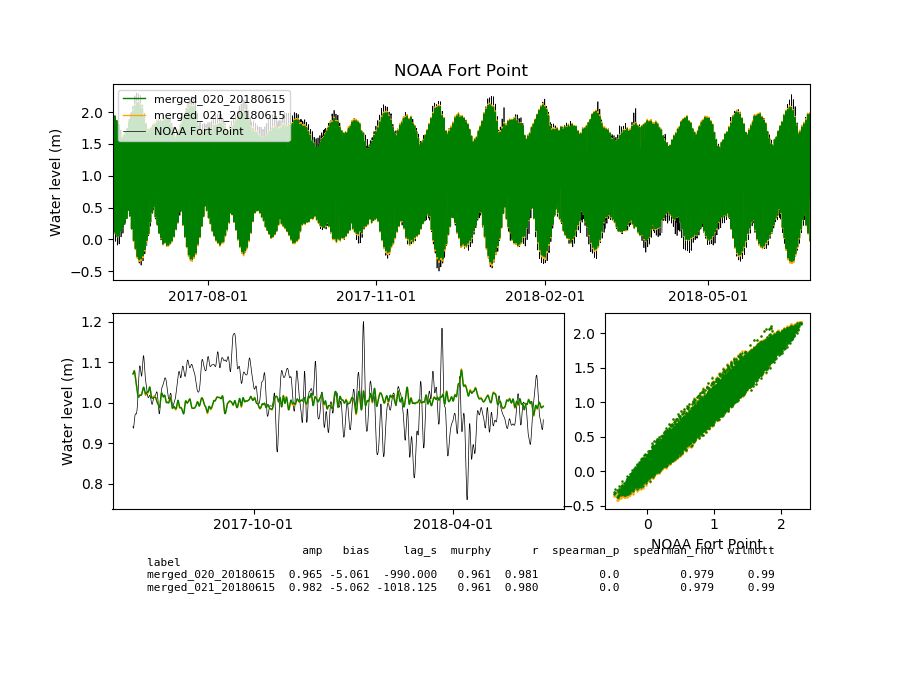

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/dates.py:1323: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  ' Defaulting to {0}.'.format(interval))


<IPython.core.display.Javascript object>


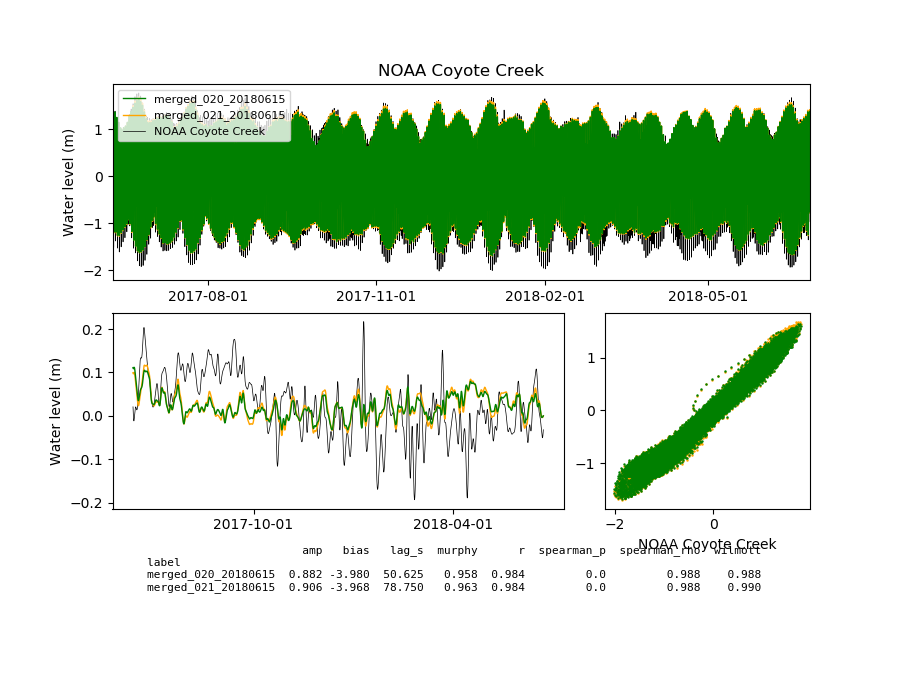

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/dates.py:1323: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  ' Defaulting to {0}.'.format(interval))


<IPython.core.display.Javascript object>


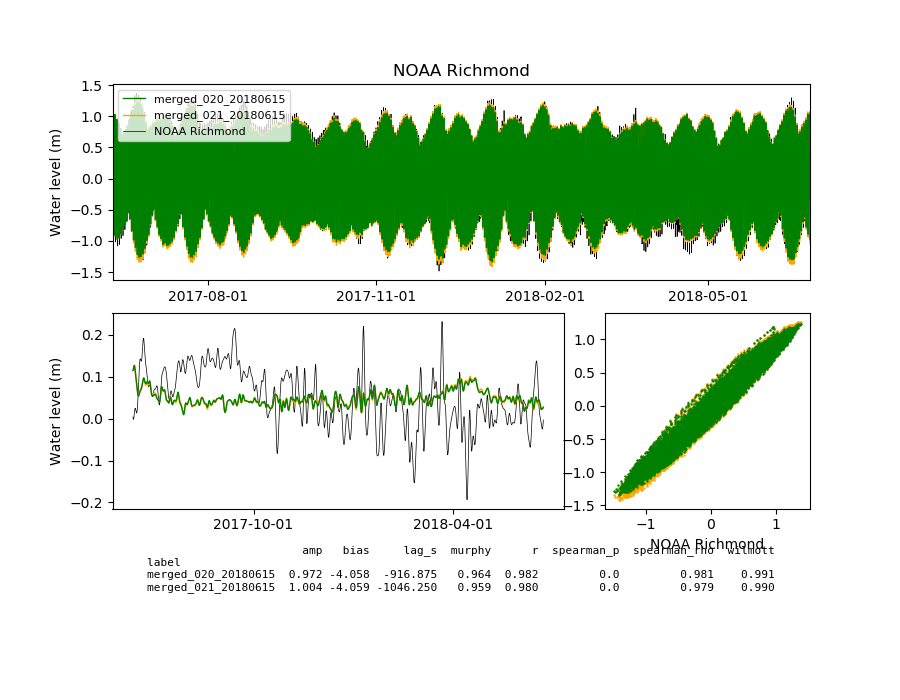

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/dates.py:1323: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  ' Defaulting to {0}.'.format(interval))


<IPython.core.display.Javascript object>


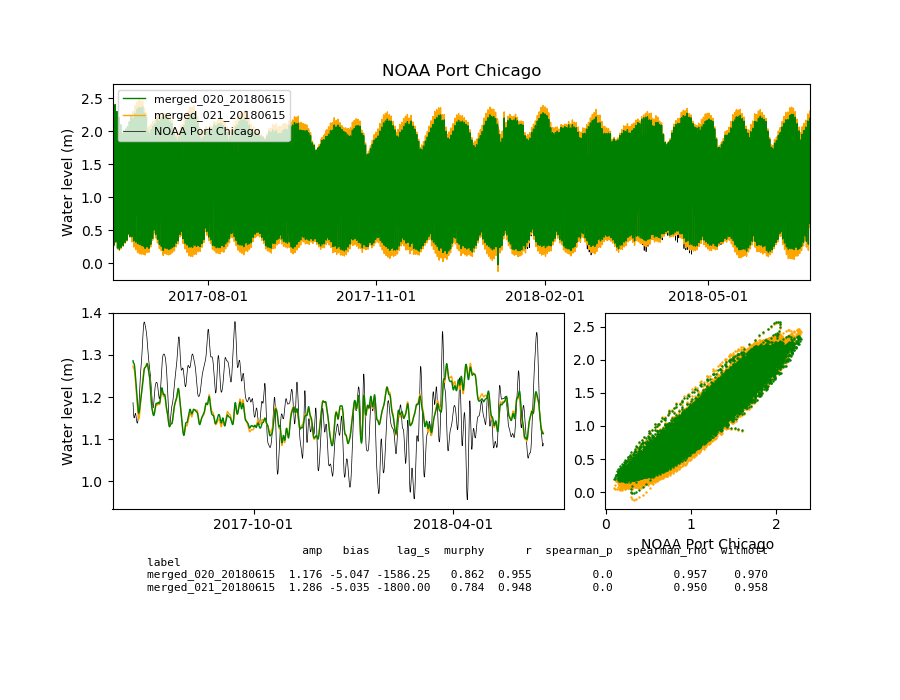

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/dates.py:1323: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  ' Defaulting to {0}.'.format(interval))


In [147]:
six.moves.reload_module(data_comparison)
model_labels=[ m.label for m in models]

for station in [alameda_wl,pointreyes_wl,sanfran_wl,coyote_wl,richmond_wl,
               portchicago_wl]:
    sources,combined=data_comparison.assemble_comparison_data(models,
                                                              [station],
                                                              model_labels=model_labels,
                                                              extract_options=dict(chain_count=start))
    fig=data_comparison.calibration_figure_3panel(sources,combined,scatter_x_source=-1,offset_source=-1,
                                                  metric_x='all',metric_ref=-1,
                                  styles=[dict(color='g',lw=1.0,zorder=1),
                                          dict(color='orange',lw=1.0,zorder=0),
                                          dict(color='k',zorder=-2,lw=0.5)])
    fig.axes[0].set_title(station.attrs['name'])
    for ax in fig.axes[:2]:
        ax.set_ylabel("Water level (m)")
    fig.savefig(os.path.join(fig_dir,"waterlevel-%s.png"%station.attrs['name'])) 


'NOAA Alameda'

<IPython.core.display.Javascript object>


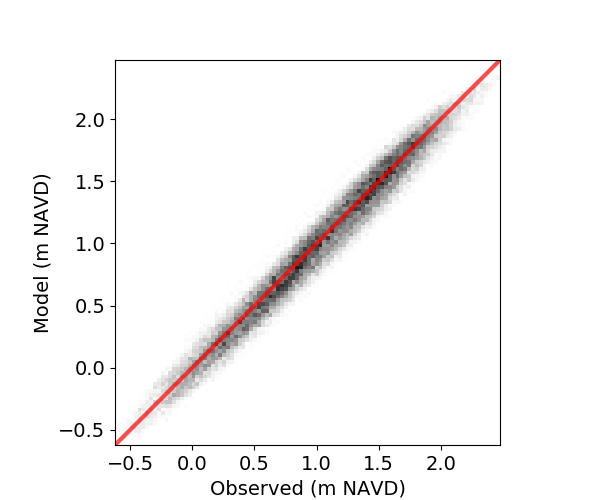

'NOAA Point Reyes'

<IPython.core.display.Javascript object>


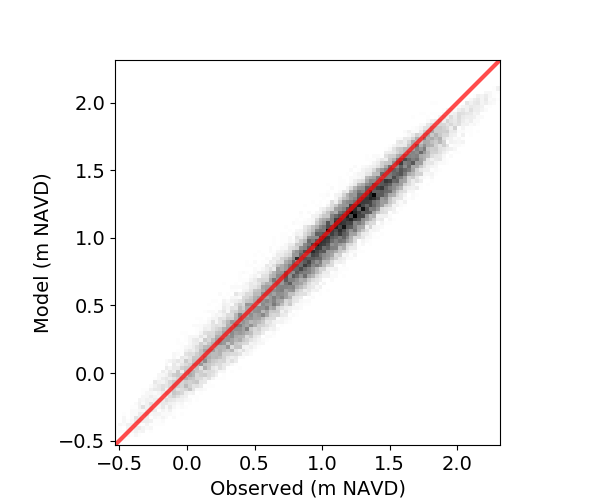

'NOAA Fort Point'

<IPython.core.display.Javascript object>


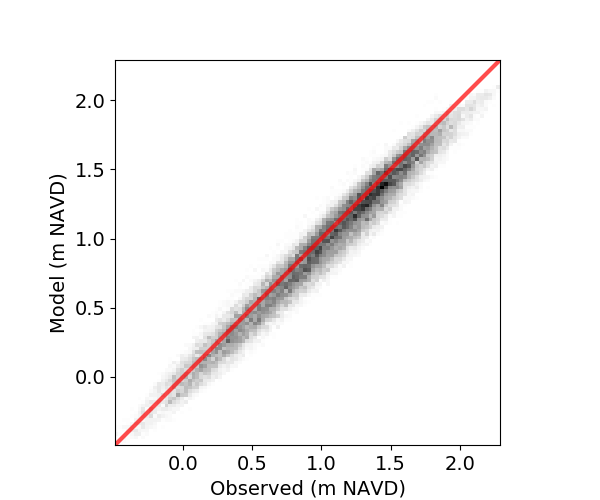

'NOAA Coyote Creek'

<IPython.core.display.Javascript object>


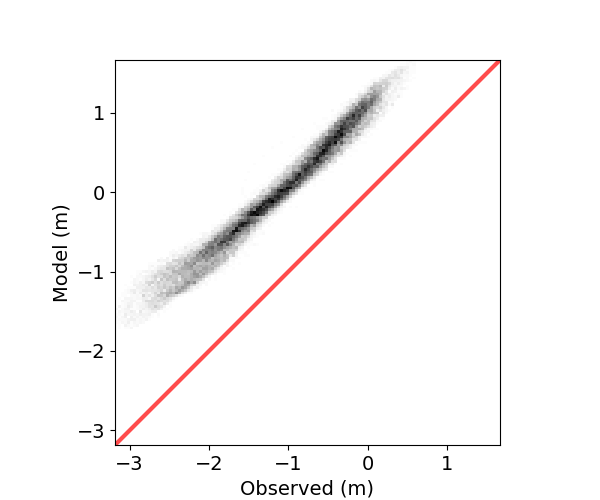

'NOAA Richmond'

<IPython.core.display.Javascript object>


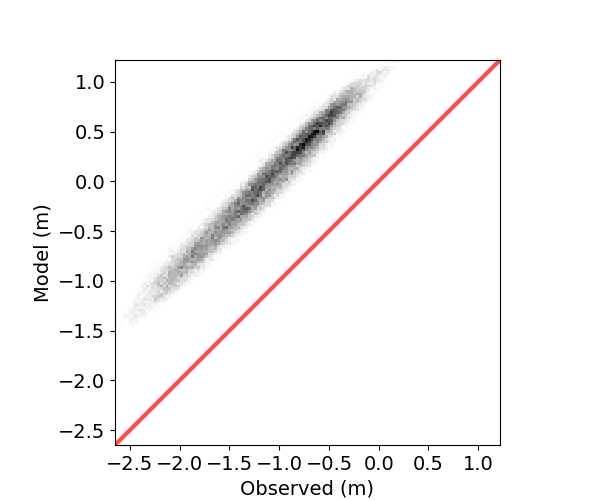

'NOAA Port Chicago'

<IPython.core.display.Javascript object>


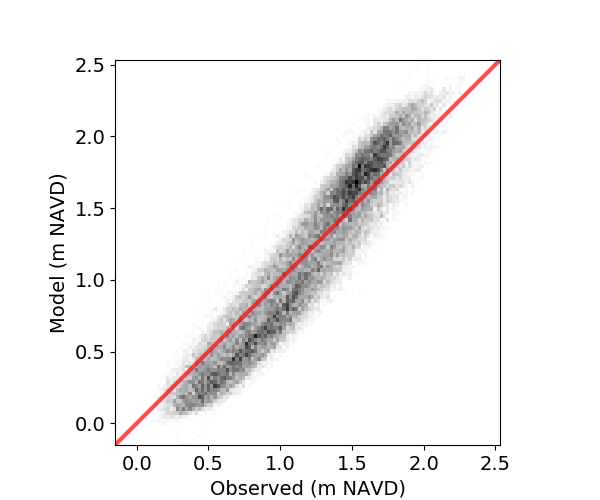

In [204]:
# 2D histogram for stage:
six.moves.reload_module(data_comparison)
model_labels=[ m.label for m in models]

eta_rows=[] # collect calibration metrics

for station in [alameda_wl,pointreyes_wl,sanfran_wl,
                coyote_wl, richmond_wl,
                portchicago_wl
                ]:
    display(station.attrs['name'])
    # This set of plots only shows a single model
    sources,combined=data_comparison.assemble_comparison_data([modelA],
                                                              [station],
                                                              model_labels=model_labels,
                                                              extract_options=dict(chain_count=start))
    
    fig=plt.figure(figsize=(6,5))
    ax=fig.add_subplot(1,1,1)
        
    model_da=combined.isel(source=0) + 5
    gage_da=combined.isel(source=1)
    
    if station.datum!='NAVD':
        model_da=model_da-np.nanmean(model_da)
        gage_da=gage_da-np.nanmean(gage)
        units='m'
    else:
        units='m NAVD'
        
    metrics=data_comparison.calc_metrics(model_da,gage_da)
    metrics['name']=station.attrs['name']
    metrics['units']=units
    eta_rows.append(metrics)
        
    ax.hist2d(gage_da.values,
              model_da.values,
              bins=100,cmap='gray_r')
    ax.set_xlabel(f'Observed ({units})',fontsize=14)
    ax.set_ylabel(f'Model ({units})',fontsize=14)
    low=min(model_da.min(),gage_da.min())
    high=max(model_da.max(),gage_da.max())
    rng=[low,high]
    ax.plot(rng,rng,'r',lw=3,zorder=2,alpha=0.7)
    #ax.axis('equal')
    ax.set_adjustable('box')
    ax.axis([low,high,low,high])
    ax.set_aspect(1)

    plt.setp(ax.get_xticklabels(),fontsize=14)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    
    img_fn="waterlevel-2dhist-%s.png"%station.attrs['name'].replace(' ','_')
    fig.savefig(os.path.join(fig_dir,img_fn),dpi=150 )
    

In [205]:
eta_rows

[{'bias': -0.023715957723737403,
  'r': 0.984269499411563,
  'lag': numpy.timedelta64(-849374996,'us'),
  'lag_s': -849.374996,
  'amp': 1.0096985361060835,
  'wilmott': 0.9916740417497705,
  'murphy': 0.9666048387098749,
  'spearman_rho': 0.9839994978252113,
  'spearman_p': 0.0,
  'name': 'NOAA Alameda',
  'units': 'm NAVD'},
 {'bias': -0.052675734637054536,
  'r': 0.9777901177808388,
  'lag': numpy.timedelta64(-1141874995,'us'),
  'lag_s': -1141.874995,
  'amp': 0.969678904895949,
  'wilmott': 0.9859370360420651,
  'murphy': 0.9458323333715623,
  'spearman_rho': 0.9760474353804706,
  'spearman_p': 0.0,
  'name': 'NOAA Point Reyes',
  'units': 'm NAVD'},
 {'bias': -0.061567524434174244,
  'r': 0.9801226132949566,
  'lag': numpy.timedelta64(-1018124996,'us'),
  'lag_s': -1018.124996,
  'amp': 0.9824802507138054,
  'wilmott': 0.9865305643386864,
  'murphy': 0.947338457258601,
  'spearman_rho': 0.9787130197444263,
  'spearman_p': 0.0,
  'name': 'NOAA Fort Point',
  'units': 'm NAVD'},
 {

In [214]:
eta_df=pd.DataFrame(eta_rows)
eta_df['Station']=[s.replace('NOAA ','') for s in eta_df.name]
eta_df=eta_df.rename(columns={
                       'murphy':"Murphy",
                       'r':'Pearson',
                       'amp':'Amp',
                       }).set_index('Station')
eta_df['Lag (min)']=eta_df['lag_s']/60.

eta_metrics=eta_df.loc[:,['Amp','Lag (min)','Pearson']]

In [220]:
#eta_metrics.style.format({'B': "{:0<4.0f}", 'D': '{:+.2f}'})
print(eta_metrics.to_latex(formatters={'Amp':lambda x: "%.2f"%x,
                                       'Lag (min)':lambda x: "%.1f"%x,
                                       'Pearson':lambda x: "%.3f"%x}))

\begin{tabular}{lrrr}
\toprule
{} &  Amp & Lag (min) & Pearson \\
Station      &      &           &         \\
\midrule
Alameda      & 1.01 &     -14.2 &   0.984 \\
Point Reyes  & 0.97 &     -19.0 &   0.978 \\
Fort Point   & 0.98 &     -17.0 &   0.980 \\
Coyote Creek & 0.91 &       1.3 &   0.984 \\
Richmond     & 1.00 &     -17.4 &   0.980 \\
Port Chicago & 1.29 &     -30.0 &   0.948 \\
\bottomrule
\end{tabular}



In [222]:
# Salinity vs. Polaris/Peterson
from stompy.io.local import usgs_sfbay
from stompy import xr_transect

In [223]:
six.moves.reload_module(usgs_sfbay)
# for now, show even the spinup period to see how things evolve
polaris=usgs_sfbay.usgs_sfbay_dataset(np.datetime64("2017-06-01"),
                                      end,cache_dir=cache_dir)

INFO:root:Will break that up into pieces
INFO:root:Cached 2017-06-01 00:00:00 -- 2017-07-01 00:00:00
INFO:root:Cached 2017-07-01 00:00:00 -- 2017-08-01 00:00:00
INFO:root:Cached 2017-08-01 00:00:00 -- 2017-09-01 00:00:00
INFO:root:Cached 2017-09-01 00:00:00 -- 2017-10-01 00:00:00
INFO:root:Cached 2017-10-01 00:00:00 -- 2017-11-01 00:00:00
INFO:root:Cached 2017-11-01 00:00:00 -- 2017-12-01 00:00:00
INFO:root:Cached 2017-12-01 00:00:00 -- 2018-01-01 00:00:00
INFO:root:Cached 2018-01-01 00:00:00 -- 2018-02-01 00:00:00
INFO:root:Cached 2018-02-01 00:00:00 -- 2018-03-01 00:00:00
INFO:root:Cached 2018-03-01 00:00:00 -- 2018-04-01 00:00:00
INFO:root:Cached 2018-04-01 00:00:00 -- 2018-05-01 00:00:00
INFO:root:Cached 2018-05-01 00:00:00 -- 2018-06-01 00:00:00
INFO:root:Cached 2018-06-01 00:00:00 -- 2018-07-01 00:00:00


In [224]:
def load_cruise(cruise_i):
    cruise=polaris.isel(cruise=cruise_i)

    cruise=cruise.sortby('Distance from 36').sortby('depth')
    cruise['d_sample']=1000*cruise['Distance from 36']
    cruise['z_ctr']=-cruise['depth']
    cruise=cruise.rename(depth='layer')
    stn_sel=np.isfinite(cruise.Salinity.max(dim='layer'))
    cruise=cruise.isel(station=stn_sel)
    return cruise

In [226]:
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

Too early
Cruise period: 2017-06-22T13:20:00.000000000 to 2017-06-22T22:17:00.000000000


<IPython.core.display.Javascript object>


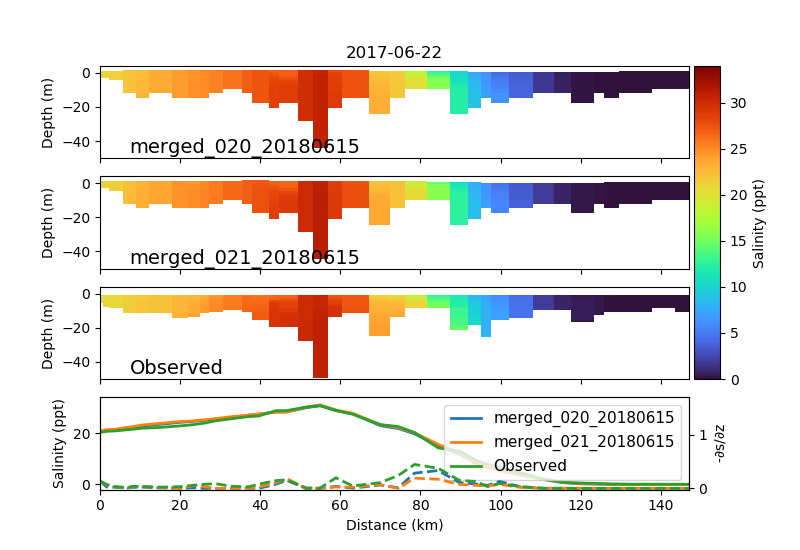

Cruise period: 2017-07-25T14:12:00.000000000 to 2017-07-25T22:26:00.000000000


<IPython.core.display.Javascript object>


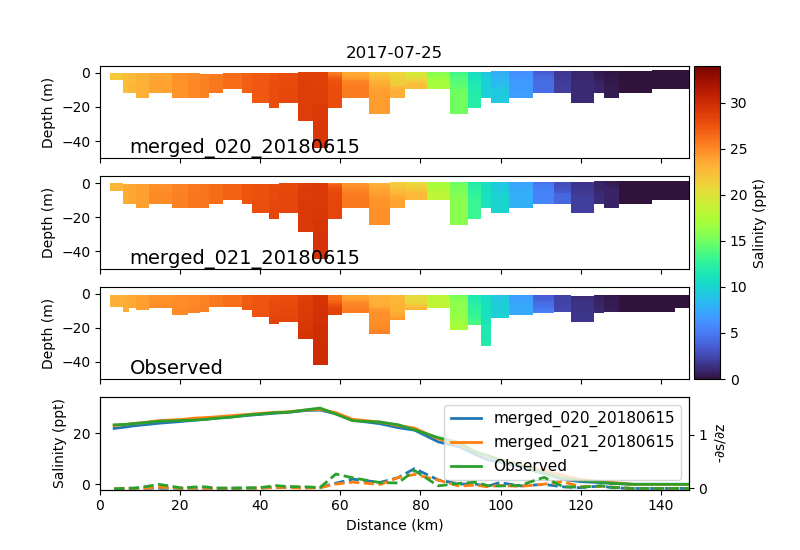

Skipping South Bay only
Cruise period: 2017-08-22T14:11:00.000000000 to 2017-08-22T22:30:00.000000000


<IPython.core.display.Javascript object>


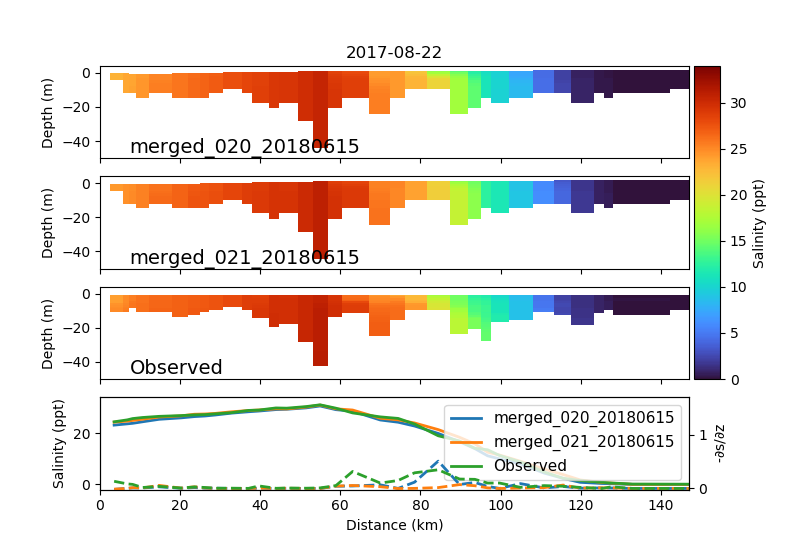

Skipping South Bay only
Cruise period: 2017-09-19T14:03:00.000000000 to 2017-09-19T21:50:00.000000000


<IPython.core.display.Javascript object>


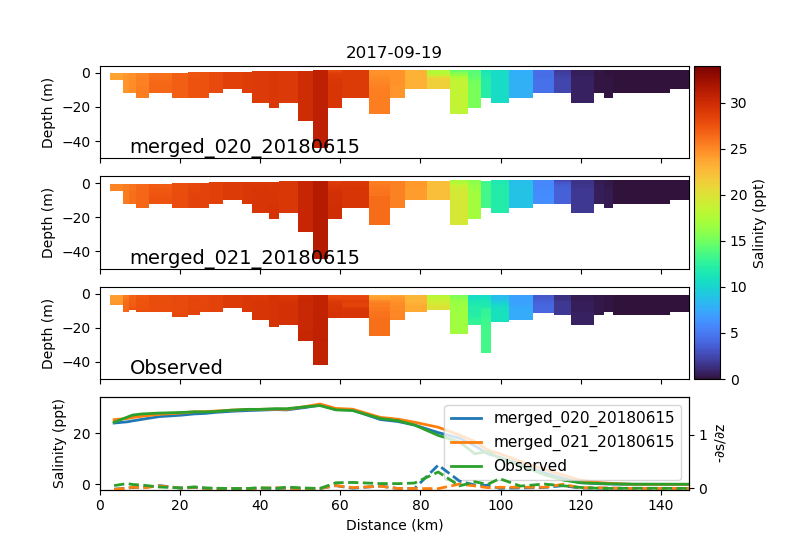

Skipping South Bay only
Cruise period: 2017-10-18T14:10:00.000000000 to 2017-10-18T22:02:00.000000000


<IPython.core.display.Javascript object>


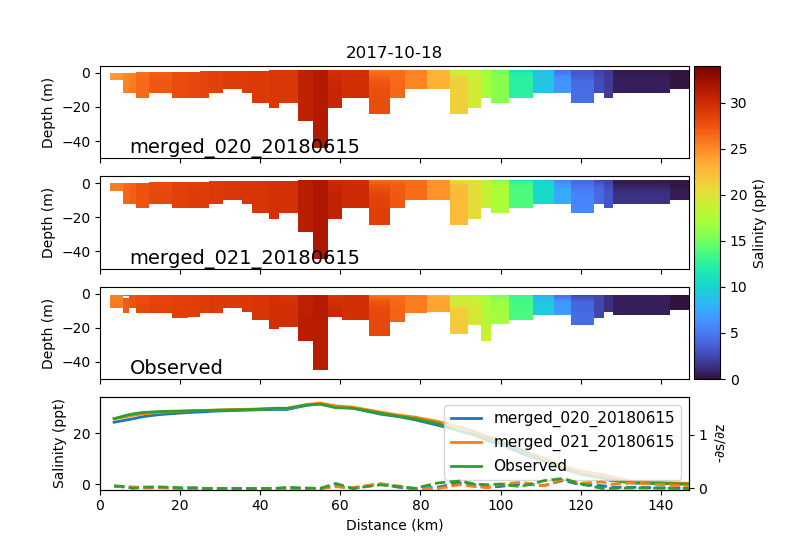

Skipping South Bay only
Cruise period: 2017-11-14T15:10:00.000000000 to 2017-11-14T23:58:00.000000000


<IPython.core.display.Javascript object>


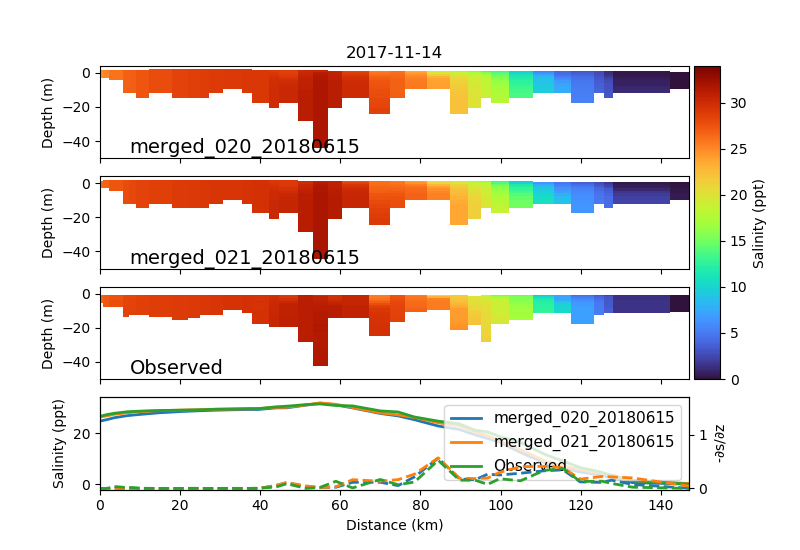

Cruise period: 2017-12-06T15:11:00.000000000 to 2017-12-06T23:21:00.000000000


<IPython.core.display.Javascript object>


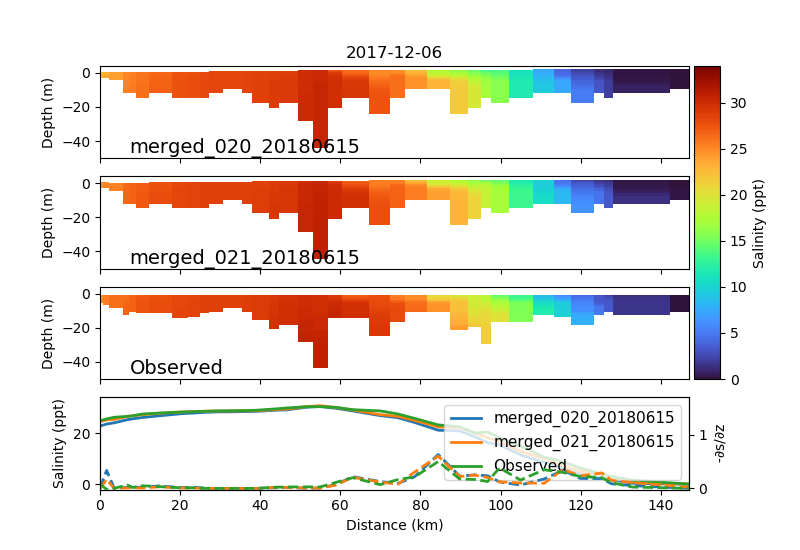

Cruise period: 2018-01-10T15:09:00.000000000 to 2018-01-10T23:52:00.000000000


<IPython.core.display.Javascript object>


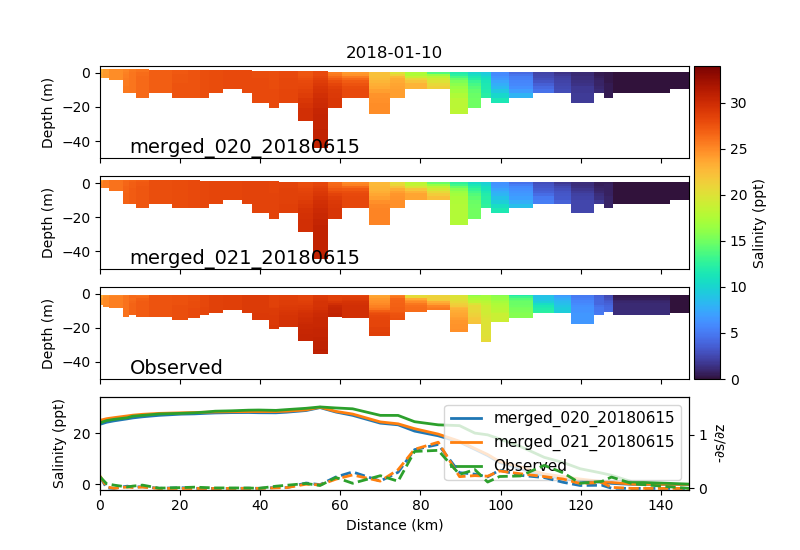

Cruise period: 2018-02-07T15:10:00.000000000 to 2018-02-08T00:06:00.000000000


<IPython.core.display.Javascript object>


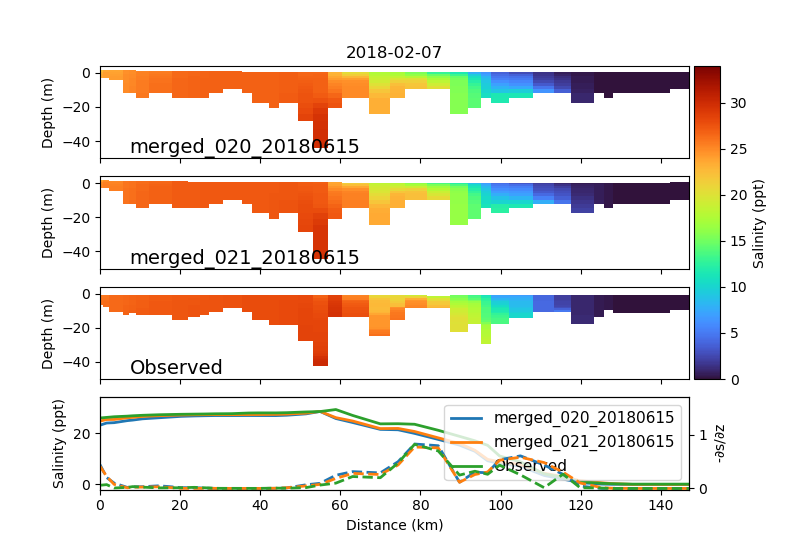

Skipping South Bay only
Skipping South Bay only
Cruise period: 2018-03-15T14:31:00.000000000 to 2018-03-15T22:48:00.000000000


<IPython.core.display.Javascript object>


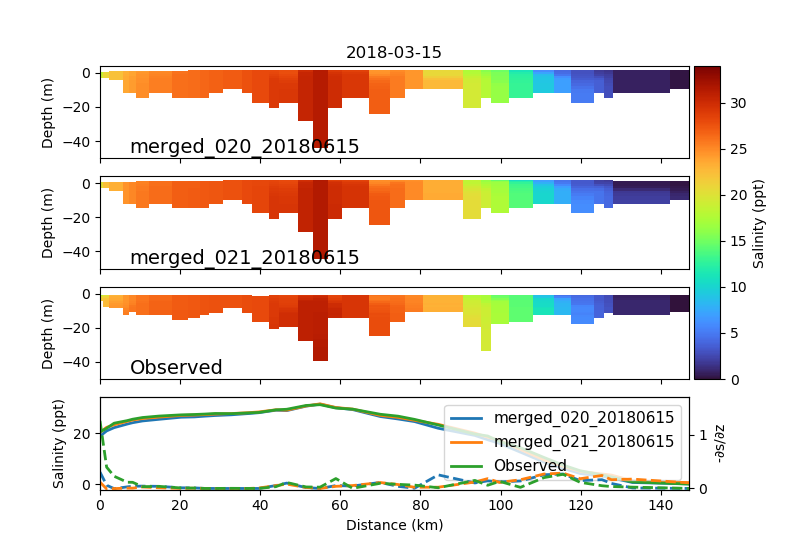

Skipping South Bay only
Skipping South Bay only
Cruise period: 2018-04-18T13:56:00.000000000 to 2018-04-18T22:03:00.000000000


<IPython.core.display.Javascript object>


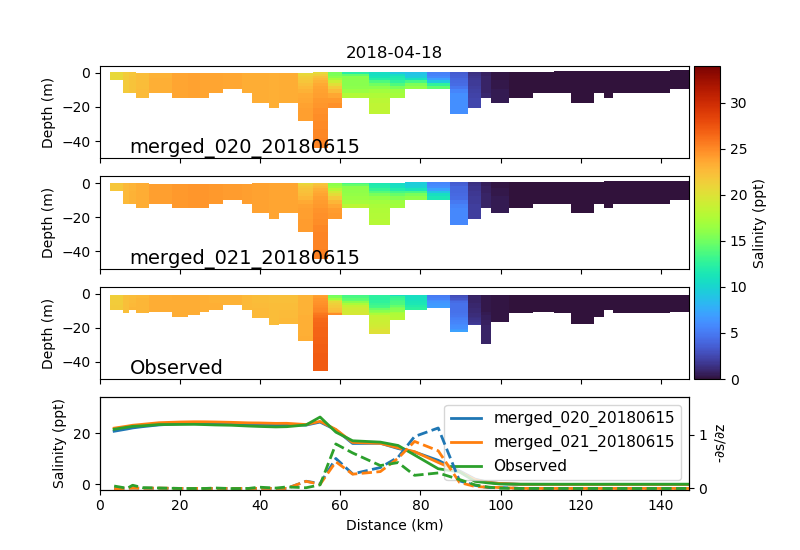

Cruise period: 2018-05-07T14:09:00.000000000 to 2018-05-07T23:43:00.000000000


<IPython.core.display.Javascript object>


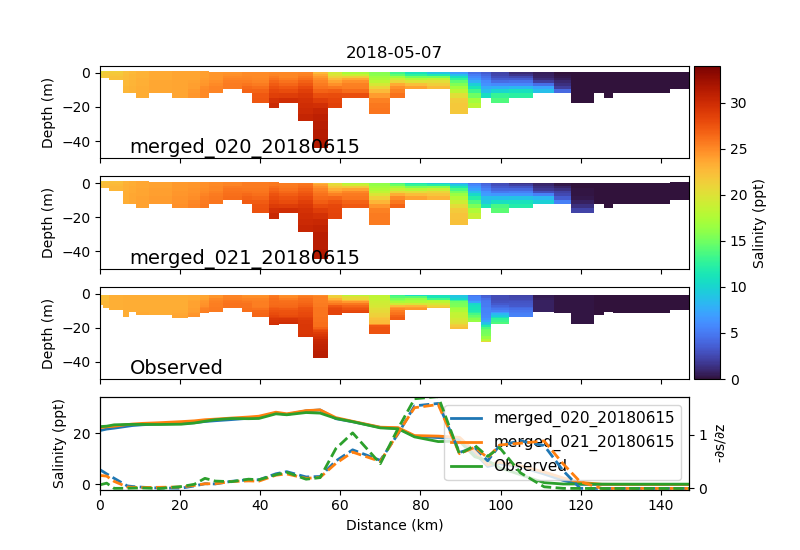

Skipping South Bay only
Skipping South Bay only
Cruise period: 2018-06-11T13:44:00.000000000 to 2018-06-11T21:14:00.000000000


<IPython.core.display.Javascript object>


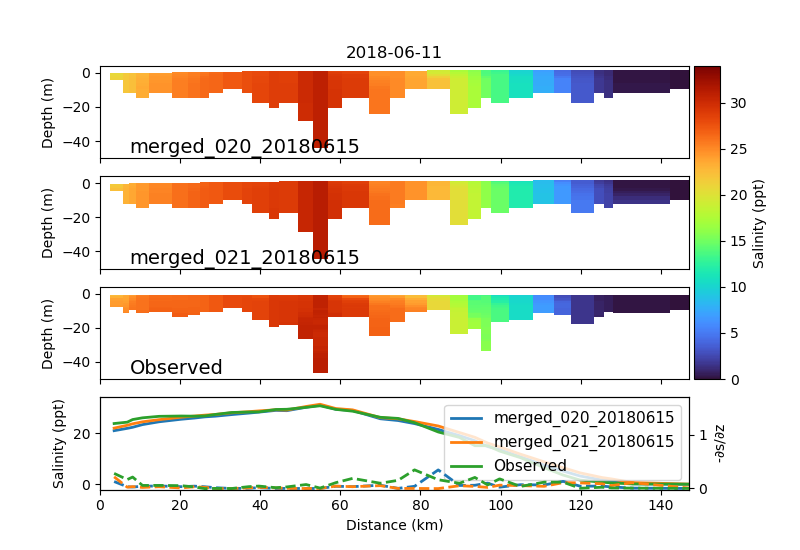

In [227]:

lag=np.timedelta64(0*3600,'s')
def plot_cruise(models,cruise,**kw):
    ll=np.c_[ cruise.longitude, cruise.latitude ]

    print(f"Cruise period: {cruise.time.values.min()} to {cruise.time.values.max()}")
    trans=[model.extract_transect_monitor(ll=ll,time=cruise.time.values+lag,dv_from_map=True,
                                          dzmin_surface=0.25)
           for model in models ]
    if all([t is None for t in trans]):
        print("Skipping")
        return None
    
    for i in range(len(trans)):
        if trans[i] is None:
            continue
        tran=trans[i].copy()

        for fld in ['eta','z_ctr','z_top','z_bot','dv']:
            if fld in tran:
                tran[fld] = tran[fld] + 5.0
        # by default d_sample is the calculated distance, but to match the
        # Polaris/Peterson data use the exact same values, which may not start
        # at 0.
        tran.d_sample.values[:]=cruise.d_sample.values
        tran['time']=tran.sample
        trans[i]=tran
    labels=[m.label for m in models] + ['Observed']
    fig=plot_transect_comparison([(tran,'salt') for tran in trans] + 
                                 [(cruise,'Salinity')],
                                 labels=labels,**kw)
    return fig
    
def plot_transect_comparison(transects, labels=None, const_lims=False):
    fig=plt.figure(figsize=(8,5.5))
    gs = gridspec.GridSpec(len(transects)+1,20)

    if labels is None:
        labels=[str(i) for i in range(len(transects))]
        
    ax0=None
    for i,(tran,fld) in enumerate(transects):
        if tran is None: continue
        ax=fig.add_subplot(gs[i,:-1],sharex=ax0,sharey=ax0)
        if ax0 is None:
            ax0=ax
        polys=xr_transect.plot_scalar( tran, fld,cmap=turbo,ax=ax, clim=[0,34])
        ax.text(0.05,0.05,labels[i],transform=ax.transAxes,fontsize=14)
        plt.setp(ax.get_xticklabels(),visible=0)
        ax.set_ylabel('Depth (m)')
        
    cax=fig.add_subplot(gs[:-1,-1])
    plt.colorbar(polys,cax=cax,label='Salinity (ppt)')

    axn=fig.add_subplot(gs[-1,:-1],sharex=ax0)
    axgrad=axn.twinx()
    
    for i,(tran,fld) in enumerate(transects):
        if tran is None: continue
        davg=xr_transect.depth_avg(tran,fld)
        axn.plot(tran.d_sample, davg,lw=2,label=labels[i])
        fld_dz=xr_transect.d_dz(tran,fld)
        axgrad.plot(tran.d_sample,-fld_dz,ls='--',lw=2)
    axn.legend(loc='upper right',fontsize=11)
    axn.set_ylabel('Salinity (ppt)')
    axgrad.set_ylabel('-$\partial$s/$\partial$z')
    axn.set_xlabel('Distance (km)')
    axn.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x,p:"%g"%(x/1000)))
    
    if not const_lims:
        # let horizontal adapt to data
        ax0.axis(ymin=-50) 
    else:
        # make limits constant for 'animating'
        ax0.axis(ymin=-50,ymax=4,xmin=0,xmax=147000)
        axn.axis(ymin=-2,ymax=34)
        axgrad.axis(ymin=-0.02,ymax=1.7)
    
    for tran,_ in transects: # use first existing transect to get date
        if tran is not None: break
    if 'time' in tran:
        t=tran['time'].min()
    elif 'sample' in tran:
        t=tran['sample'].min()
    ax0.set_title(utils.to_datetime(t).strftime("%Y-%m-%d"))
    return fig

for cruise_i in range(polaris.dims['cruise']):
    cruise=load_cruise(cruise_i)
    if cruise.cruise.values < np.datetime64("2017-06-15"):
        print("Too early")
        continue
    if cruise.d_sample.max() < 120000:
        print("Skipping South Bay only")
        continue 
    ll=np.c_[ cruise.longitude, cruise.latitude ]
    
    date_str=utils.to_datetime(cruise.cruise.values).strftime("%Y-%m-%d")
    img_fn=os.path.join(fig_dir,"polaris-const-full-%s.png"%date_str)
    
    fig=plot_cruise(models,cruise,const_lims=True)
    if fig is None: continue
    
    fig.savefig(img_fn,dpi=150)
    

<IPython.core.display.Javascript object>


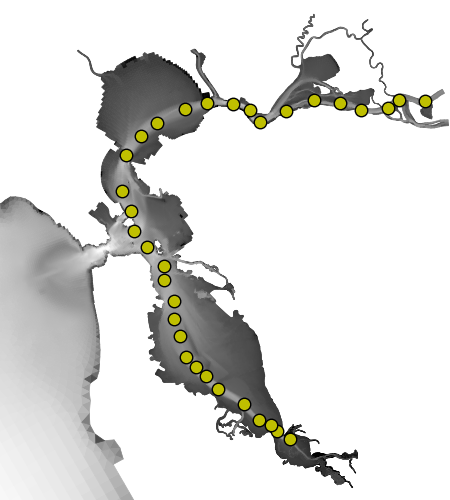

In [140]:
# Example of cruise track
fig,ax=plt.subplots(1,1,figsize=(4.5,5))
from matplotlib.colors import LogNorm
models[0].grid.plot_cells(ax=ax,values=(-2-model.grid.cells['depth']).clip(1),
                          cmap='gray',norm=LogNorm(vmin=1,vmax=100),
                          lw=0.5,edgecolor='face')

model=models[0]
cruise_xy=model.ll_to_native( np.c_[ cruise.longitude.values, cruise.latitude.values])

ax.plot(cruise_xy[:,0], cruise_xy[:,1],'yo',mec='k',ms=9)
ax.axis('equal')
ax.axis('off')
ax.axis( (525900, 610000, 4.142e6, 4.229e6) )
#ax.xaxis.set_visible(0)
#ax.yaxis.set_visible(0)
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
fig.savefig('grid-and-polaris.png',dpi=150)

In [ ]:
# Summarize skill metrics for polaris salinity?
# or is there bridge-based salinity I can use instead?

def get_cruise_data(models,cruise,**kw):
    ll=np.c_[ cruise.longitude, cruise.latitude ]

    print(f"Cruise period: {cruise.time.values.min()} to {cruise.time.values.max()}")
    trans=[model.extract_transect_monitor(ll=ll,time=cruise.time.values+lag,dv_from_map=True,
                                          dzmin_surface=0.25)
           for model in models ]
    if all([t is None for t in trans]):
        print("Skipping")
        return None
    
    for i in range(len(trans)):
        if trans[i] is None:
            continue
        tran=trans[i].copy()

        for fld in ['eta','z_ctr','z_top','z_bot','dv']:
            if fld in tran:
                tran[fld] = tran[fld] + 5.0
        # by default d_sample is the calculated distance, but to match the
        # Polaris/Peterson data use the exact same values, which may not start
        # at 0.
        tran.d_sample.values[:]=cruise.d_sample.values
        tran['time']=tran.sample
        trans[i]=tran
    labels=[m.label for m in models] + ['Observed']
    return [(tran,'salt') for tran in trans] + 
           [(cruise,'Salinity')],
                                 labels=labels,**kw)
    return fig
    

for cruise_i in range(polaris.dims['cruise']):
    cruise=load_cruise(cruise_i)
    if cruise.cruise.values < np.datetime64("2017-06-15"):
        print("Too early")
        continue
    if cruise.d_sample.max() < 120000:
        print("Skipping South Bay only")
        continue 
    print(cruise)
    ll=np.c_[ cruise.longitude, cruise.latitude ]
    
    date_str=utils.to_datetime(cruise.cruise.values).strftime("%Y-%m-%d")
    
    fig=plot_cruise(models,cruise,const_lims=True)
    